In [1]:
import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):

    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    return samples

In [3]:
def potential_grad(sample, mu, cov):

    precision = jnp.linalg.inv(cov)

    return (sample - mu) @ precision

In [4]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=5, seed=0):
    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples

    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - eps * grad + jnp.sqrt(2 * eps) * noise

    return evolved_samples

In [5]:
def sliced_wasserstein_distance(x, y, n_proj=100, p=2, seed=0):

    key = jax.random.PRNGKey(seed)
    d = x.shape[1]

    # Generate n_proj random directions on the unit sphere
    proj_dirs = jax.random.normal(key, shape=(n_proj, d))
    proj_dirs = proj_dirs / jnp.linalg.norm(proj_dirs, axis=1, keepdims=True)  # normalize

    def sw_per_direction(proj):
        x_proj = jnp.sort(x @ proj)  # shape (n,)
        y_proj = jnp.sort(y @ proj)  # shape (m,)
        n = x_proj.shape[0]
        m = y_proj.shape[0]
        min_n = min(n, m)
        # interpolate if n ≠ m, or just truncate to smallest length
        x_proj = x_proj[:min_n]
        y_proj = y_proj[:min_n]
        return jnp.mean(jnp.abs(x_proj - y_proj) ** p)

    # Apply over all projections
    sw_vals = jax.vmap(sw_per_direction)(proj_dirs)
    sw_dist = (jnp.mean(sw_vals)) ** (1 / p)
    return sw_dist


In [6]:
def lm_loss(samples, mu, cov):

    evolved_samples = evolve_langevin(samples, mu, cov)

    return sliced_wasserstein_distance(samples, evolved_samples)

In [7]:
def lm_optimize_with_tracking(samples, true_mu, true_cov, n_epochs=1000, lr=1e-2, seed=10, eps=1e-2, plot_every=2):
    n, d = samples.shape

    key = jax.random.PRNGKey(seed)
    key_mu, key_A = jax.random.split(key)

    mu = jax.random.normal(key_mu, shape=(d,))
    A = jax.random.normal(key_A, shape=(d, d))

    params = {
        "mu": mu,
        "A": A
    }

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)

    history = {
        "loss": [],
        "mu_l2": [],
        "cov_l2": [],
        "cov_fro": [],
    }

    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        # Tracking
        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val

        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_l2"].append(jnp.linalg.norm(true_cov - cov_val, ord=2))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))

        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")

    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]

    return final_mu, final_cov, history


In [8]:
mu = jnp.array([0.0, 1.0, -1.0])

cov = jnp.array([
    [1.0, 0.5, 0.2],
    [0.5, 1.0, 0.3],
    [0.2, 0.3, 1.0]
])

In [9]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)

final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=800, lr=0.05, seed = 0)

epoch 0 | loss = 0.084760
epoch 2 | loss = 0.060983
epoch 4 | loss = 0.052537
epoch 6 | loss = 0.049293
epoch 8 | loss = 0.047832
epoch 10 | loss = 0.047025
epoch 12 | loss = 0.046468
epoch 14 | loss = 0.045994
epoch 16 | loss = 0.045509
epoch 18 | loss = 0.044928
epoch 20 | loss = 0.044162
epoch 22 | loss = 0.043161
epoch 24 | loss = 0.041978
epoch 26 | loss = 0.040820
epoch 28 | loss = 0.040102
epoch 30 | loss = 0.040246
epoch 32 | loss = 0.040636
epoch 34 | loss = 0.040400
epoch 36 | loss = 0.040004
epoch 38 | loss = 0.039717
epoch 40 | loss = 0.039462
epoch 42 | loss = 0.039295
epoch 44 | loss = 0.039283
epoch 46 | loss = 0.039207
epoch 48 | loss = 0.038939
epoch 50 | loss = 0.038677
epoch 52 | loss = 0.038488
epoch 54 | loss = 0.038301
epoch 56 | loss = 0.038093
epoch 58 | loss = 0.037867
epoch 60 | loss = 0.037585
epoch 62 | loss = 0.037246
epoch 64 | loss = 0.036895
epoch 66 | loss = 0.036521
epoch 68 | loss = 0.036088
epoch 70 | loss = 0.035599
epoch 72 | loss = 0.035077
epoch 

In [10]:
jnp.set_printoptions(precision=4, suppress=True)

print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov), "\n\n\n")

[ 0.  1. -1.] 

 [-0.0194  1.0405 -0.9028] 0.10705623 



[[1.  0.5 0.2]
 [0.5 1.  0.3]
 [0.2 0.3 1. ]] 

 [[1.0547 0.4499 0.2082]
 [0.4499 0.9151 0.1764]
 [0.2082 0.1764 1.2071]] 0.2979779 





In [11]:
history_np = {k: np.array(v) for k, v in history.items()}

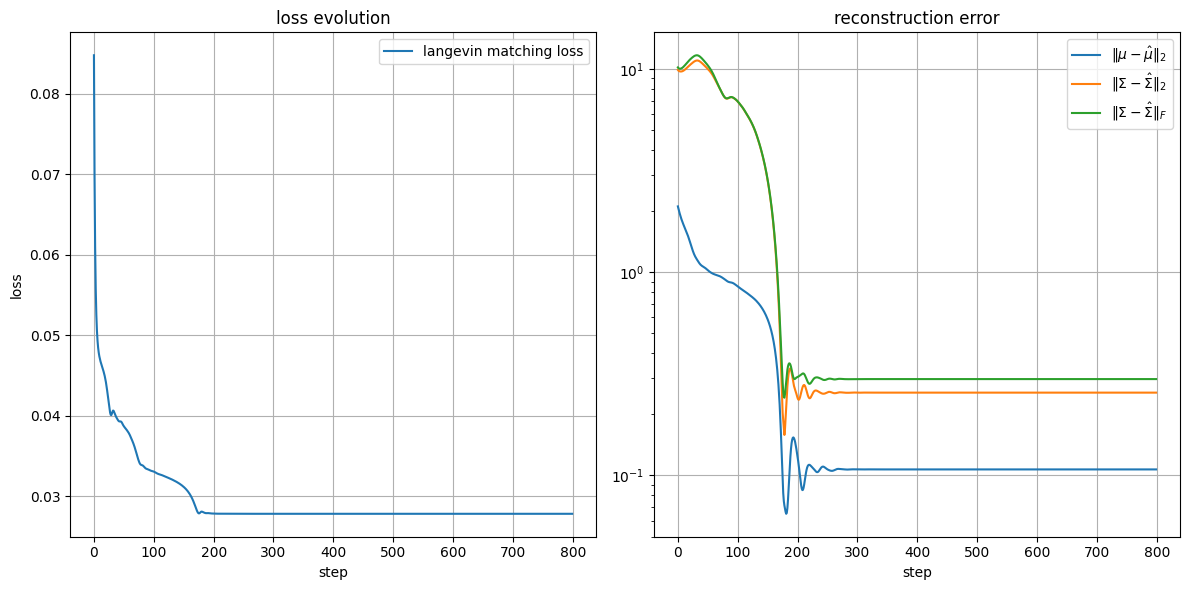

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="langevin matching loss")
plt.xlabel("step")
plt.ylabel("loss")
plt.title("loss evolution")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"], label=r"$\| \mu - \hat{\mu} \|_2$")
plt.plot(history_np["cov_l2"], label=r"$\| \Sigma - \hat{\Sigma} \|_2$")
plt.plot(history_np["cov_fro"], label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.yscale("log")
plt.xlabel("step")
plt.title("reconstruction error")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()